In [2]:
import pandas as pd
import numpy as np 
import os
import plotly.express as px
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from matplotlib import pyplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import random

# For investigating timeseries data
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

# For modeling
import xgboost

### Loading Data

In [3]:
# Reading Data
base_path =  os.getcwd()
file_name = 'Traffic_Data.xlsx'
total_path = base_path + '//Data//' 
df = pd.read_excel(total_path + file_name, sheet_name='Sheet1')

# Filtering for just one state
df = df[df['State'] == 'Oregon']
df = df.sort_values(by = ['Date'])
df.head(10)

,State,Region,STATIONS,CMILES,PMILES,Month,Month_2,Year,Date
3056,Oregon,West,153,2823,2769,January,1,2019,2019-01-01
3005,Oregon,West,143,2393,2566,February,2,2019,2019-02-01
2954,Oregon,West,153,3088,3104,March,3,2019,2019-03-01
2903,Oregon,West,152,3034,2990,April,4,2019,2019-04-01
2852,Oregon,West,147,3303,3295,May,5,2019,2019-05-01
2801,Oregon,West,154,3334,3318,June,6,2019,2019-06-01
2750,Oregon,West,153,3547,3527,July,7,2019,2019-07-01
2699,Oregon,West,152,3587,3541,August,8,2019,2019-08-01
2648,Oregon,West,155,3246,3216,September,9,2019,2019-09-01
2597,Oregon,West,157,3241,3185,October,10,2019,2019-10-01


### Creating Model

In [4]:
model = xgboost.XGBRegressor()

### Transforming Data
For our regressor to work we need to turn the problem from a timeseries problem to a regression one. We can do this by offsetting our dataset by x steps so that we can prediction time T based on teh value at T-x

In [25]:
# Defining function to convert time series problem into supervised learning problem
def convert_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 
 df = pd.DataFrame(data)
 cols = list()
 # Training sequence (t-n, ... t-1)
 for i in range(0, n_in):
    print(i)
    cols.append(df.shift(i))

 # Forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    print(i)
    cols.append(df.shift(-i))

 # Concatenating columns together
 agg = pd.concat(cols, axis=1)
 
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values


# Function to split into test/train set based on time
def train_test_split(data, n_test):
   return data[:-n_test, :], data[-n_test:, :]

# Fit xgboost model based on histroric data and making prediction for next timestamp
def forecast(train, testX):
 
 train = np.asarray(train)
 # splitting into input/output
 x_train, y_train = train[:, :-1], train[:, -1]
 # fitting model
 model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(x_train, y_train)

 # making a prediction
 y_predicted = model.predict(np.asarray([testX]))
 return y_predicted[0]


def stepwise_prediction(data, n_test):
 
 '''Iterates through timeseries data, fitting a new model for data up to
 time t and making prediction for time t+1'''
 
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]

 # Iterating through dataset one timestep at a time
 for i in range(len(test)):
   # Creating new test and train dataset for each timestep
   testX, testy = test[i, :-1], test[i, -1]
   # Fitting model and making prediction for next step
   y_pred = forecast(history, testX)
   # store forecast in list of predictions
   predictions.append(y_pred)

 return  predictions

### Fitting Model

In [26]:
values = df['CMILES'].values
print(values)
# Transforming to time series                                                                                                                                                       
data = convert_to_supervised(values, n_in=6)
print(data.shape)
print(data)

[2823 2393 3088 3034 3303 3334 3547 3587 3246 3241 2778 2942 2694 2637
 2457 1949 2429 2850 3299 3345 2894 3017 2472 2567 2379 2418 2935 2890
 3052 3226 3488 3336 3092 2988 2805 2671 2612 2537 2956 2869 3044 3176
 3372 3376 3141 3072 2692 2676  746 2452 2964 2942 3263 3407 3549 3481
 3222 3180 2864 2817]
0
1
2
3
4
5
0
(55, 7)
[[3334. 3303. 3034. 3088. 2393. 2823. 3334.]
 [3547. 3334. 3303. 3034. 3088. 2393. 3547.]
 [3587. 3547. 3334. 3303. 3034. 3088. 3587.]
 [3246. 3587. 3547. 3334. 3303. 3034. 3246.]
 [3241. 3246. 3587. 3547. 3334. 3303. 3241.]
 [2778. 3241. 3246. 3587. 3547. 3334. 2778.]
 [2942. 2778. 3241. 3246. 3587. 3547. 2942.]
 [2694. 2942. 2778. 3241. 3246. 3587. 2694.]
 [2637. 2694. 2942. 2778. 3241. 3246. 2637.]
 [2457. 2637. 2694. 2942. 2778. 3241. 2457.]
 [1949. 2457. 2637. 2694. 2942. 2778. 1949.]
 [2429. 1949. 2457. 2637. 2694. 2942. 2429.]
 [2850. 2429. 1949. 2457. 2637. 2694. 2850.]
 [3299. 2850. 2429. 1949. 2457. 2637. 3299.]
 [3345. 3299. 2850. 2429. 1949. 2457. 3345

In [9]:
# Evaluating
y_pred = walk_forward_validation(data, 12)
print(y_pred)

>expected=746.0, predicted=2613.0
>expected=2452.0, predicted=2354.8
>expected=2964.0, predicted=2715.9
>expected=2942.0, predicted=2956.7
>expected=3263.0, predicted=3237.1
>expected=3407.0, predicted=2976.3
>expected=3549.0, predicted=3425.7
>expected=3481.0, predicted=3436.8
>expected=3222.0, predicted=3168.7
>expected=3180.0, predicted=3105.2
>expected=2864.0, predicted=2747.3
>expected=2817.0, predicted=2820.9
MAE: 258.324


>expected=746.0, predicted=2613.0
>expected=2452.0, predicted=2354.8
>expected=2964.0, predicted=2715.9
>expected=2942.0, predicted=2956.7
>expected=3263.0, predicted=3237.1
>expected=3407.0, predicted=2976.3
>expected=3549.0, predicted=3425.7
>expected=3481.0, predicted=3436.8
>expected=3222.0, predicted=3168.7
>expected=3180.0, predicted=3105.2
>expected=2864.0, predicted=2747.3
>expected=2817.0, predicted=2820.9
MAE: 258.324


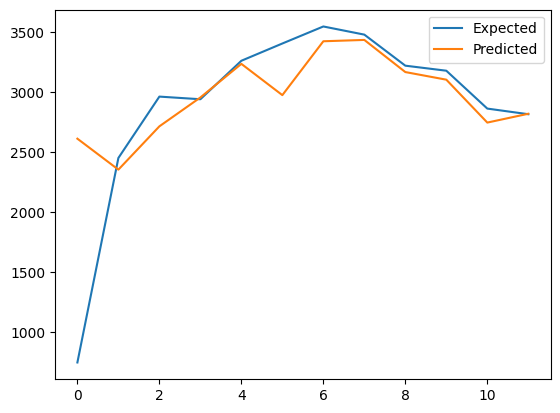

In [10]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()